# SVM Model

In this notebook, we will train dataset using SVM model. We will first look into the dataset (Data Analysis), try different combinations of hyperparameter using GridSearchCV, and some sanity check. 

## Section 1 - Data Sanity Check / Analysis

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [8]:
data = pd.read_csv('sign_mnist_train.csv')
data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


In [9]:
y_train = data['label']
X_train = data.drop(columns = 'label')

### Check if there is any N/A value

In [10]:
data.isna().any().sum()

0

### Check distribution of labels

In [11]:
column_val = 'pixel{value}'
for i in range(1, 785):
    if (data[column_val.format(value=i)] < 0).any() or (data[column_val.format(value=i)] > 255).any():
        print("Unexpected value encountered in pixel column {value}".format(value=i))

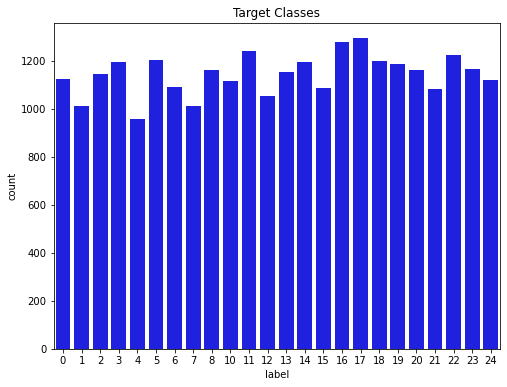

In [12]:
plt.figure(figsize = (8,6))
sns.countplot(x = data['label'], color = 'b')
plt.title('Target Classes')
plt.show()

As we can see the graph above, we can see that there are roughly same amount of labels in the train dataset. Also, we don't see any corrupted values like np.na() or non-integer values in our dataset. That being said, our dataset is well-collected and maintained.

### Simple GridSearchCV (for checking data normalization) <a id='basic_grid_search'></a>

We will run a simple GridSearchCV using SVM to check the data normalization. The reason is because GridSearchCV will break the train data into k number of folds, and use one fold as a validation test. Since it breaks down the train dataset, it allows us to solely test on train dataset as well as increase the efficiency of runtime. 

In [20]:
# Prerequisite
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [7]:
model = SVC(random_state=42)
p_grid = {'C': [0.01],
          'kernel': ['linear', 'poly', 'rbf']}
grid_diff_kernel = GridSearchCV(estimator=model, param_grid=p_grid, n_jobs=-1, verbose=3)
grid_diff_kernel.fit(X_train, y_train)

# View the Grid Search CV Results
print(grid_diff_kernel.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'mean_fit_time': array([ 68.23706579,  89.78885002, 733.17273879]), 'std_fit_time': array([ 0.71482898,  1.3821868 , 11.63549734]), 'mean_score_time': array([ 18.3835362 ,  29.16101565, 107.87945457]), 'std_score_time': array([ 0.22060432,  1.07987018, 12.9156282 ]), 'param_C': masked_array(data=[0.01, 0.01, 0.01],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'poly', 'rbf'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.01, 'kernel': 'linear'}, {'C': 0.01, 'kernel': 'poly'}, {'C': 0.01, 'kernel': 'rbf'}], 'split0_test_score': array([1.        , 0.99981788, 0.35640138]), 'split1_test_score': array([1.        , 1.        , 0.35002732]), 'split2_test_score': array([1.        , 1.        , 0.35002732]), 'split3_test_score': array([1.        , 1.        , 0.35257694]), 'split4_t

From the GridSearchCV with regularization parameter of 0.01 (and tested onto different kernel types), we see the validation score of 1.0 for linear and poly kernel in contrast to rbf kernel which shows average score of 0.35. This tells us that our data might be too-normalized so that the train dataset's same label dataset are equal to each other. We can test this claim by using low-neighbor KNN. That way, KNN acts like linear kernel of SVM. If we see the same if not really close to the score of 1, then our claim is true.

On the other hand, we see the SVM kernel type "RBF" is performing drastically worse than other kernels. That can possibly mean that the gamma type of RBF setting is not accurate / relevant to our dataset. Let's test several different types of gamma value to find optimal gamma value.

### Claim Test - Low neighbor of K-NN

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

rf = KFold(n_splits=2, shuffle=True, random_state=42)

model = KNeighborsClassifier()
p_grid = {'n_neighbors':[1,2,3,5,10]}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, cv=rf, verbose=3)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV 1/2] END .....................n_neighbors=1;, score=0.997 total time=   4.6s
[CV 2/2] END .....................n_neighbors=1;, score=0.998 total time=   3.7s
[CV 1/2] END .....................n_neighbors=2;, score=0.993 total time=   4.0s
[CV 2/2] END .....................n_neighbors=2;, score=0.994 total time=   4.3s
[CV 1/2] END .....................n_neighbors=3;, score=0.992 total time=   5.1s
[CV 2/2] END .....................n_neighbors=3;, score=0.994 total time=   4.2s
[CV 1/2] END .....................n_neighbors=5;, score=0.988 total time=   5.5s
[CV 2/2] END .....................n_neighbors=5;, score=0.987 total time=   4.5s
[CV 1/2] END ....................n_neighbors=10;, score=0.967 total time=   5.0s
[CV 2/2] END ....................n_neighbors=10;, score=0.971 total time=   4.5s
{'mean_fit_time': array([0.08092296, 0.05262494, 0.05003464, 0.05487835, 0.05060446]), 'std_fit_time': array([0.02823985, 0.001036

As we can see, the values are really close to 1, thus our claim is true. 

#### Claim Test - different Gamma value for RBF Kernel

In [8]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

model = SVC(random_state=42)
p_grid = {'gamma': ['scale', 'auto', 0.01, 0.05, 0.1, 0.5, 1],
          'kernel': ['rbf']}
clf1 = GridSearchCV(estimator=model, param_grid=p_grid, verbose=3)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.5min
[CV 2/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.3min
[CV 3/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.5min
[CV 4/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.4min
[CV 5/5] END ...........gamma=scale, kernel=rbf;, score=1.000 total time= 1.5min
[CV 1/5] END ............gamma=auto, kernel=rbf;, score=0.228 total time= 7.9min
[CV 2/5] END ............gamma=auto, kernel=rbf;, score=0.223 total time= 7.6min
[CV 3/5] END ............gamma=auto, kernel=rbf;, score=0.225 total time= 7.7min
[CV 4/5] END ............gamma=auto, kernel=rbf;, score=0.222 total time= 7.4min
[CV 5/5] END ............gamma=auto, kernel=rbf;, score=0.230 total time= 8.0min
[CV 1/5] END ............gamma=0.01, kernel=rbf;, score=0.114 total time= 8.3min
[CV 2/5] END ............gamma=0.01, kernel=rbf;,

From the above GridSearchCV that search through all possibilities of gamma values for RBF kernel, we see that the gamma kernel of 'Scale' (which is equivalent to 1 / (n_features * X.var()) (more in https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)) performs just like other kernels. Therfore, let's restrict kernel gamma to scale.

## Section 2 - Data Augmentation

In order to make the model more suitable for real-world examples (rather than lab-recorded dataset), we need to perform data augmentation to artificially create noise inside the dataset. One way to perform that is to reduce the dimension of the dataset (called PCA).

### PCA (Principal Component Analysis)

PCA is unsupervised machine-learning algorithm where it takes the dataset and reduce the dimensionality of the dataset  (https://en.wikipedia.org/wiki/Principal_component_analysis). We will then use GridSearchCV with pipeline to test PCA and SVM at the same time.

#### Small test - PCA with linear kernel SVM

From previous test runs (outside this notebook), somehow it takes forever to compile when PCA is used with Linear kernel. Here is the example:

### Warning

While the dataset doesn't seem to have too much rows (around 26000 rows), Scikit-learn takes a very long time to compute things, especially when PCA is used with Linear kernel (I do not know why). For the sake of time efficiency, let's try to make things faster by using some parameters like __cache_size__ (for storing temporary variable in model when training) and __n_jobs__ (how many separate task (i.e. fold run) can be done in each core (my computer has 8 cores so it will run 8 tasks at the same time))

In [12]:
# We are setting n_components to different areas of possibility thus check how drastically changes the time / accuracy of dataset.
p_grid = {
    'pca__n_components': [700, 300, 100, 50]
}
pipe = Pipeline([('pca', PCA(random_state=42)), ('svc', SVC(C=0.01, kernel='linear', cache_size=1999, random_state=42))]) 
clf1 = GridSearchCV(estimator=pipe, param_grid=p_grid, verbose=3, n_jobs=-1)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'mean_fit_time': array([75.26194773, 41.27091503,  9.34750409,  7.55208526]), 'std_fit_time': array([0.57237614, 2.44280091, 0.44735386, 0.80971876]), 'mean_score_time': array([15.75234404,  7.3494204 ,  1.38403702,  0.64936724]), 'std_score_time': array([0.31601637, 1.38837362, 0.389974  , 0.04816348]), 'param_pca__n_components': masked_array(data=[700, 300, 100, 50],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'pca__n_components': 700}, {'pca__n_components': 300}, {'pca__n_components': 100}, {'pca__n_components': 50}], 'split0_test_score': array([1., 1., 1., 1.]), 'split1_test_score': array([1., 1., 1., 1.]), 'split2_test_score': array([1., 1., 1., 1.]), 'split3_test_score': array([1., 1., 1., 1.]), 'split4_test_score': array([1., 1., 1., 1.]), 'mean_test_score': array([1., 1., 1., 1.]), 'std_test_score': array([0., 0., 0., 0.]), 'rank_test_score': array([1, 

As we can see from the result above, pca_component size (feature-column size) of anything above 50 will still give you very normalized data that it still gives you a perfect score. Let's decrease the component size (from 5 to 60).

In [13]:
p_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    'svc__C': [0.01], # Since we are focusing on which component value is optimal, we are not going to change the regularization value.
    'svc__kernel': ['linear', 'poly']}
pipe = Pipeline([('pca', PCA(random_state=42)), ('svc', SVC(cache_size=1999, random_state=42))])
clf1 = GridSearchCV(estimator=pipe, param_grid=p_grid, verbose=3, n_jobs=-1)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)
grid_linear_poly = clf1.cv_results_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'mean_fit_time': array([1918.47475948,   27.96860881, 1098.46126995,   26.18182139,
        537.73966956,   30.2976233 ,  258.18313227,   29.34500732,
        135.46505847,   31.66797023,   40.10501871,   33.92367687,
         12.54630308,   40.13219981,    7.4743134 ,   39.35367866,
          8.00691719,   50.46842885,    8.60241375,   49.87005506,
          8.48674688,   63.82301259,   10.18633833,   48.49237084]), 'std_fit_time': array([33.45048961,  0.29086695, 17.63531914,  0.28744654, 15.15424827,
        0.53714971, 11.42143255,  0.98975632,  6.62103725,  0.62092791,
        5.14965049,  0.39230995,  0.84628085,  0.34478383,  0.13210564,
        0.21179303,  0.43919949,  0.77097953,  0.5779149 ,  0.62261116,
        0.13750444,  2.50729394,  0.81513107,  3.95914487]), 'mean_score_time': array([ 5.40619459,  6.1879889 ,  4.36161995,  5.57761173,  2.95357685,
        6.35781889,  1.78103447,  6.09950252,  1.35715513,  

In [14]:
print("Best parameter of Linear/Poly Kernel: ", clf1.best_params_)
print("Best Score of Linear / Poly Kernel: ", clf1.best_score_)

Best parameter of Linear/Poly Kernel:  {'pca__n_components': 50, 'svc__C': 0.01, 'svc__kernel': 'linear'}
Best Score of Linear / Poly Kernel:  1.0




Let's test the RBF kernel too.

In [15]:
# Testing PCA for 'RBF' kernel
p_grid = {
    'pca__n_components': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    'svc__C': [0.01], # Since we are focusing on which component value is optimal, we are not going to change the regularization value.
    'svc__kernel': ['rbf'],
    'svc__gamma': ['scale']}
pipe = Pipeline([('pca', PCA(random_state=42)), ('svc', SVC(random_state=42))])
clf1 = GridSearchCV(estimator=pipe, param_grid=p_grid, verbose=3, n_jobs=-1)
clf1.fit(X_train, y_train)

# View the Grid Search CV Results
print(clf1.cv_results_)
grid_rbf = clf1.cv_results_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'mean_fit_time': array([50.29998698, 49.94038792, 49.12089791, 48.06392303, 54.41043253,
       56.73895192, 67.66116009, 69.30856676, 85.30464482, 84.76618829,
       94.3587162 , 68.67289391]), 'std_fit_time': array([ 0.1559263 ,  2.49010184,  0.31646644,  0.40426127,  0.82797678,
        0.7070342 ,  4.69053264,  1.05824271,  1.82131365,  3.44063325,
        2.01249865, 11.69126772]), 'mean_score_time': array([15.3093173 , 15.58400145, 15.69540343, 17.42663965, 18.87039485,
       19.858425  , 20.64061041, 20.75806875, 21.90898509, 22.20817199,
       24.84659057, 17.34311681]), 'std_score_time': array([0.13776552, 0.55584517, 0.11601892, 0.72353089, 1.11525479,
       1.0289236 , 0.58945541, 0.60176642, 0.79959887, 1.65582223,
       1.80327319, 2.78220381]), 'param_pca__n_components': masked_array(data=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
             mask=[False, False, False, False, False, False, False, Fa

In [16]:
print("Best parameter of RBF Kernel: ", clf1.best_params_)
print("Best Score of the best parameter: ", clf1.best_score_)

Best parameter of RBF Kernel:  {'pca__n_components': 30, 'svc__C': 0.01, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}
Best Score of the best parameter:  0.41580768530322343


In [17]:
# Collect scores for linear/poly grid test
param_linear_poly = grid_linear_poly['params']
param_rbf = grid_rbf['params']

temp = np.array([])
for i in range(5):
    index = "split{iter}_test_score"
    temp = np.append(temp, grid_linear_poly[index.format(iter=i)], axis=0)

temp = temp.reshape(5, 24)
score_linear = temp[:, 0::2]
score_poly = temp[:, 1::2]

score_rbf = np.array([])
for i in range(5):
    index = "split{iter}_test_score"
    score_rbf = np.append(score_rbf, grid_rbf[index.format(iter=i)])
score_rbf = score_rbf.reshape(5, 12)

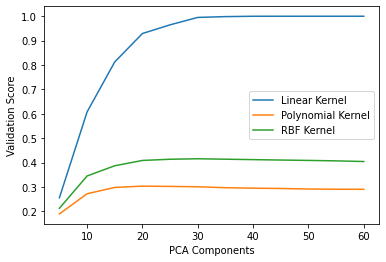

In [38]:
# Visualization of graph
import matplotlib.pyplot as plt

plt.plot(np.arange(5, 65, 5), score_linear.mean(axis=0), label="Linear Kernel")
plt.plot(np.arange(5, 65, 5), score_poly.mean(axis=0), label="Polynomial Kernel")
plt.plot(np.arange(5, 65, 5), score_rbf.mean(axis=0), label='RBF Kernel')
plt.xlabel("PCA Components")
plt.ylabel("Validation Score")
plt.legend()
plt.show()

All the results above shows that even with PCA, the validation score from GridSearchCV is still returning 1 (after 50 components).

As we can see from above graph, while linear kernel do exceptionally well as the PCA component value increases, other two kernels like polynomial and rbf kernels tend to not increase its validation score after 30 components. We can say that the other kernels are not really relevant with our dataset style. 

### HOG (History of Orientated Gradients)

HOG is the feature extraction method that is specifically used in visual processing. It extracts the canny edge of the image objects, which can be helpful when we need to simplify dataset.

#### Some Examples with HOG

In [9]:
from skimage.feature import hog

hog_dataset = []

for i in range(X_train.shape[0]):
    fd, hog_image = hog(image=np.asarray(X_train.iloc[i]).reshape(28,28), pixels_per_cell=(4,4), block_norm='L2', visualize=True)
    hog_dataset.append(hog_image.flatten())

hog_dataset = np.asarray(hog_dataset)
hog_dataset.shape

(27455, 784)

#### Original Image

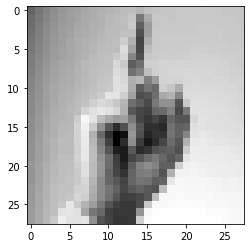

In [34]:
test = np.asarray(X_train.iloc[0]).reshape((28,28))
plt.imshow(test, cmap = 'gray')

#### HOG image

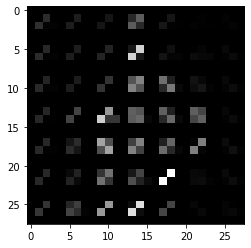

In [35]:
plt.imshow(hog_dataset[0].reshape(28,28), cmap = 'gray')

Let's run basic GridSearchCV on HOG dataset and compare with initial GridSearchCV results [here](#basic_grid_search)

In [10]:
model = SVC(random_state=42)
p_grid = {'C': [0.01],
          'kernel': ['linear', 'poly', 'rbf']}
grid_hog_diff_kernel = GridSearchCV(estimator=model, param_grid=p_grid, n_jobs=-1, verbose=3)
grid_hog_diff_kernel.fit(hog_dataset, y_train)

# View the Grid Search CV Results
print(grid_hog_diff_kernel.cv_results_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'mean_fit_time': array([ 37.17686749, 977.98079052, 935.11098213]), 'std_fit_time': array([  0.4057579 ,   6.00294786, 348.40958095]), 'mean_score_time': array([ 20.70937772, 164.06094351, 110.14429321]), 'std_score_time': array([ 0.29254423,  3.14963767, 32.22482535]), 'param_C': masked_array(data=[0.01, 0.01, 0.01],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'poly', 'rbf'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.01, 'kernel': 'linear'}, {'C': 0.01, 'kernel': 'poly'}, {'C': 0.01, 'kernel': 'rbf'}], 'split0_test_score': array([0.99981788, 0.61537061, 0.61008924]), 'split1_test_score': array([0.99908942, 0.62975779, 0.61227463]), 'split2_test_score': array([1.        , 0.61446003, 0.59788745]), 'split3_test_score': array([1.        , 0.62465853, 0.60936077]), 'split

In [15]:
normal_score = []
for i in range(5):
    index = "split{iter}_test_score"
    normal_score.append(grid_diff_kernel.cv_results_[index.format(iter=i)])

hog_score = []
for i in range(5):
    index = "split{iter}_test_score"
    hog_score.append(grid_hog_diff_kernel.cv_results_[index.format(iter=i)])

normal_score = np.array(normal_score).T
hog_score = np.array(hog_score).T

In [39]:
print("Normal Score: \n", normal_score.T)
print('\n')
print("HOG Score: \n", hog_score.T)

Normal Score: 
 [[1.         0.99981788 0.35640138]
 [1.         1.         0.35002732]
 [1.         1.         0.35002732]
 [1.         1.         0.35257694]
 [1.         1.         0.35895101]]


HOG Score: 
 [[0.99981788 0.61537061 0.61008924]
 [0.99908942 0.62975779 0.61227463]
 [1.         0.61446003 0.59788745]
 [1.         0.62465853 0.60936077]
 [1.         0.62866509 0.61537061]]


Text(0, 0.5, 'Validation Score')

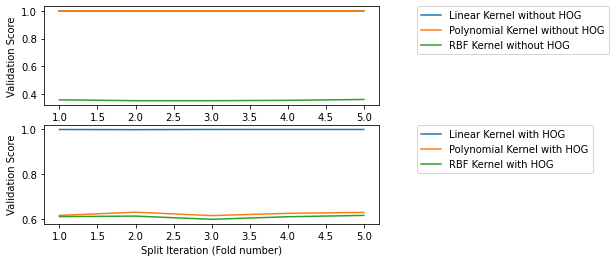

In [35]:
fig = plt.figure()
ax1 = plt.subplot(2,1,1)
ax1.plot(np.arange(1,6), normal_score[0], label='Linear Kernel without HOG')
ax1.plot(np.arange(1,6), normal_score[1], label='Polynomial Kernel without HOG')
ax1.plot(np.arange(1,6), normal_score[2], label='RBF Kernel without HOG')
ax1.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("Split Iteration (Fold number)")
plt.ylabel("Validation Score")

ax2 = plt.subplot(2,1,2)
ax2.plot(np.arange(1,6), hog_score[0], label='Linear Kernel with HOG')
ax2.plot(np.arange(1,6), hog_score[1], label='Polynomial Kernel with HOG')
ax2.plot(np.arange(1,6), hog_score[2], label='RBF Kernel with HOG')
ax2.legend(bbox_to_anchor=(1.1, 1.05))
plt.xlabel("Split Iteration (Fold number)")
plt.ylabel("Validation Score")

In here, we see several things. First of all, we see that the linear kernel doesn't get affected by HOG feature. On the other hand, HOG dataset works worse on polynomial kernel whereas RBF kernel takes advantages of it. While it is unclear to analyze how HOG dataset is related to different kernel's calculation, we can analyze that the linear kernel still works best.

## Section 3 - Conclusion

Finally, let's try to find the best hyperparameter that will maximize the test score.

In [4]:
p_grid = {
    'pca__n_components': [25, 30, 35, 40, 45],
    'svc__C': [0, 0.01, 0.05, 0.1, 0.5], 
    'svc__kernel': ['linear', 'poly', 'rbf'],
    'svc__gamma': ['scale']
}
pipe = Pipeline([('pca', PCA(random_state=42)), ('svc', SVC(cache_size=1999, random_state=42))])
grid_final = GridSearchCV(estimator=pipe, param_grid=p_grid, verbose=3, n_jobs=-1)
grid_final.fit(X_train, y_train)

# View the Grid Search CV Results
print(grid_final.cv_results_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


C:\Users\yok018\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
75 fits failed out of a total of 375.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yok018\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yok018\Anaconda3\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\yok018\Anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=s

{'mean_fit_time': array([2.16226039e+00, 2.56322737e+00, 2.64119835e+00, 1.51390828e+02,
       3.40644684e+01, 5.74525435e+01, 7.20068227e+02, 3.10705153e+01,
       3.28906359e+01, 1.34180212e+03, 2.51879582e+01, 2.53026333e+01,
       5.92288019e+03, 1.64356461e+01, 1.34012190e+01, 1.32412071e+00,
       1.30338783e+00, 1.25845041e+00, 4.84791143e+01, 4.35457026e+01,
       5.95543916e+01, 1.68824326e+02, 3.16019293e+01, 3.52098317e+01,
       3.47865553e+02, 2.92726154e+01, 3.05005126e+01, 1.47630436e+03,
       1.73122757e+01, 1.32733500e+01, 1.32441840e+00, 1.46270280e+00,
       1.45367589e+00, 1.54029744e+01, 4.32305442e+01, 5.86337173e+01,
       2.70438900e+01, 2.61055577e+01, 2.82303244e+01, 4.40099582e+01,
       2.23987532e+01, 2.08013363e+01, 1.85642091e+02, 1.43017556e+01,
       1.05480298e+01, 1.12195191e+00, 1.15746469e+00, 1.18752203e+00,
       6.35643544e+00, 3.36903858e+01, 4.76223241e+01, 6.58251190e+00,
       2.71725523e+01, 2.95420422e+01, 6.99657235e+00, 2.39

Now that the GridSearchCV has completed, let's find out the best hyperparameter setting.

In [2]:
grid_final.best_params_

{'pca__n_components': 45,
 'svc__C': 0.01,
 'svc__gamma': 'scale',
 'svc__kernel': 'linear'}

Let's use this setting to create model with it, then find teting score.

In [3]:
data2= pd.read_csv('sign_mnist_test.csv')
data2

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


In [4]:
y_test = data2['label']
X_test = data2.drop(columns = 'label')

In [51]:
final_result = Pipeline([('pca', PCA(n_components=45)), ('svc', SVC(random_state=42, C=0.01, kernel='linear', cache_size=1999))])
final_result.fit(X_train, y_train)
final_result.score(X_test, y_test)

0.7803959843837145

The testing score of the dataset is 0.78. This is really far from the validation score (1 vs. 0.78). That means, there are some hypothesis with it.

1. Train / Test dataset are different (in a sense of test dataset has more noise in the data)
2. Since Train dataset was too normalized, the model was already overfitted

### Claim 1 - Different Train / Test dataset

In order for us to actually test if train/test datasets are different, we can test it by merging two dataset and shuffle dataset. Then create model then find test score.

In [17]:
dataset_merge = pd.concat([data, data2])
dataset_merge

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


In [18]:
dataset_merge.isna().any().sum()

0

In [21]:
dataset_merge = dataset_merge.sample(frac=1) # Shuffling dataset
y = dataset_merge['label']
X = dataset_merge.drop(columns = 'label')

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Run same code as original best hyperparameter setting
pipe = Pipeline([('pca', PCA(n_components=45)), ('svc', SVC(random_state=42, C=0.01, kernel='linear', cache_size=1999))])
pipe.fit(X_train_all, y_train_all)
pipe.score(X_test_all, y_test_all)

1.0

Above testing score shows 1. That being said, it matches with our validation score from original dataset, thus telling us that our claim is true (train and test dataset are different). Therefore, we can test our other claim.

### Claim 2 - Dataset overfit

There may be a case where our hyperparameter setting still overfits the model. Let's test it using the merged dataset.

In [23]:
# decrease the regularization as well as component for PCA
pipe = Pipeline([('pca', PCA(n_components=25)), ('svc', SVC(random_state=42, C=0.001, kernel='linear', cache_size=1999))])
pipe.fit(X_train_all, y_train_all)
pipe.score(X_test_all, y_test_all)

0.9439792087785157

Considering the original data's feature size (equivalent to n_components in PCA) is 784, we really compressed the value about 20 times, it still gives us the really high score (but not 1). That means, data was too normalized in a sense that very small regularization results a overfit in the dataset. Since dataset is not what we have collected, we cannot do anything further from here. Thus, we should be satisfied with what we have. 

## Area Under Curve (ROC) (Multiclassifier) <a id='multiclassifier'></a>

Since we cannot directly use our dataset into ROC (Receiver Operating Characteristics), we would have to use multiclass converter. There are two types of multiclass analyzer:

1. One vs. All 
2. One vs. One

We've seen these two strategies in lecture. Luckly, Scikit-learn supports these features too.

### One vs. All 

In [56]:
X_train_pca = PCA(n_components=45).fit(X_train, y_train).transform(X_train)

In [57]:
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import roc_curve, auc
from tqdm import tqdm_notebook

model = SVC(random_state=42, C=0.01, kernel='linear', cache_size=1999)
ovr = OneVsRestClassifier(model, n_jobs=-1)
ovr.fit(X_train, y_train)
y_score_ovr = ovr.decision_function(X_test)

In [58]:
print(sorted(y_test.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [59]:
y_test_one_hot = np.zeros((y_test.shape[0], 25)) # 24 = # of unique labels (so it becomes suitable for roc_curve function requirement)
for i in range(y_test.shape[0]):
    y_test_one_hot[i][y_test[i]] =1

# Since 9 is not present in our dataset, remove the column
y_test_one_hot = np.delete(y_test_one_hot, 9, 1)

In [60]:
fpr_ovr = dict()
tpr_ovr = dict()
roc_auc_ovr = dict()
for i in tqdm_notebook(range(24)):
    fpr_ovr[i], tpr_ovr[i], _ = roc_curve(y_test_one_hot[:, i], y_score_ovr[:, i])
    roc_auc_ovr[i] = auc(fpr_ovr[i], tpr_ovr[i])

C:\Users\yok018\AppData\Local\Temp/ipykernel_34512/4062437829.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(24)):


  0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\yok018\AppData\Local\Temp/ipykernel_34512/3831793648.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(24)):


  0%|          | 0/24 [00:00<?, ?it/s]

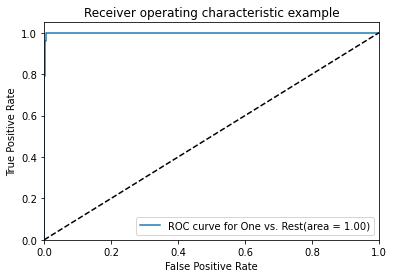

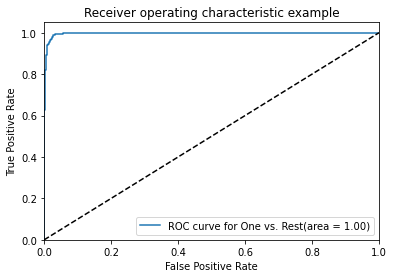

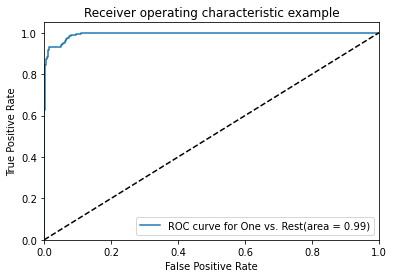

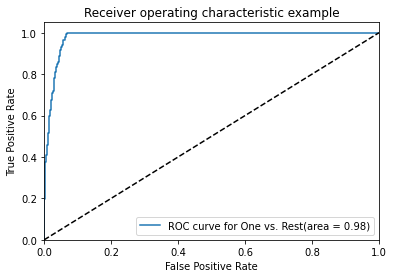

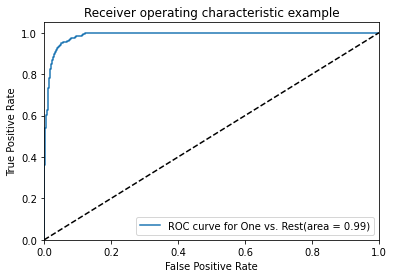

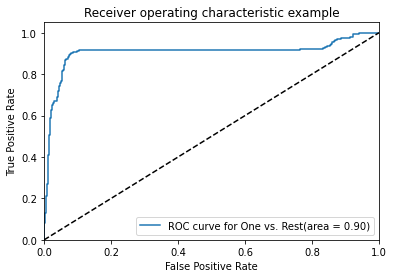

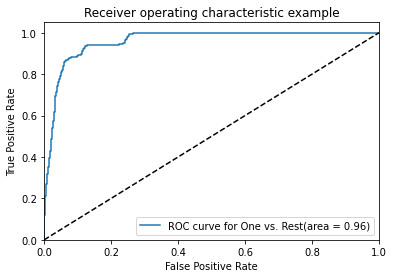

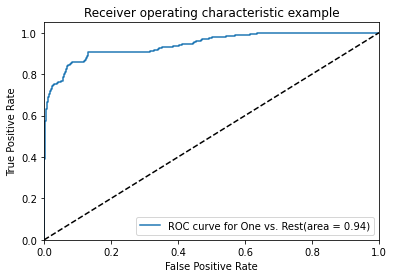

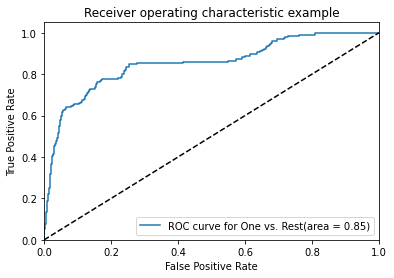

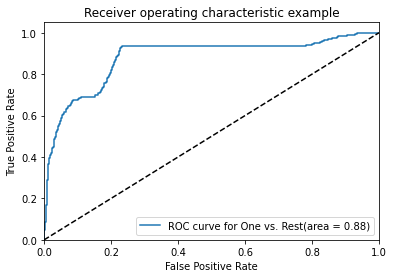

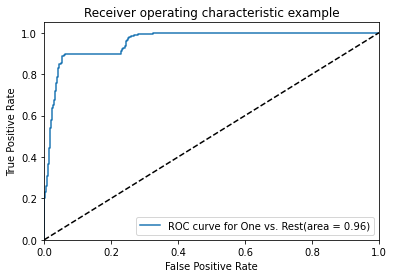

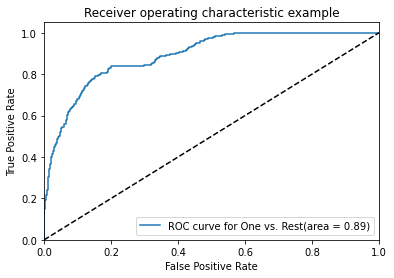

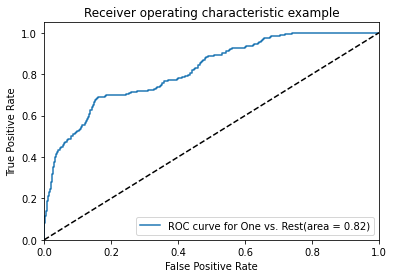

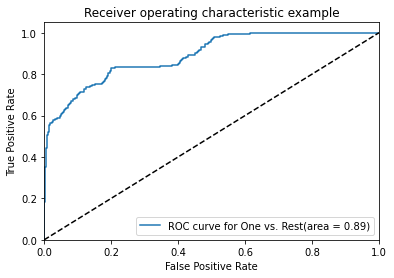

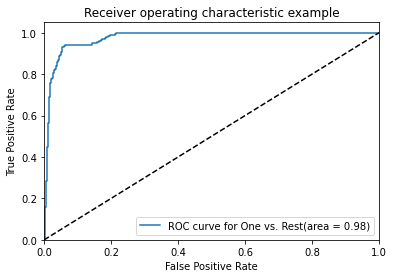

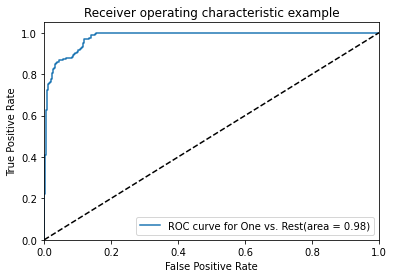

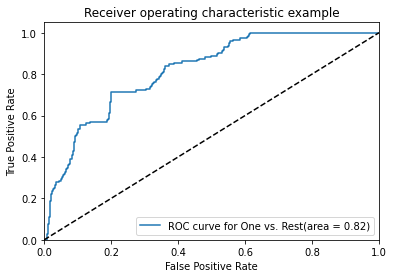

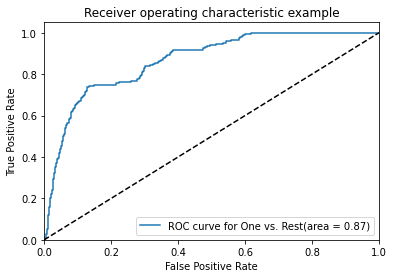

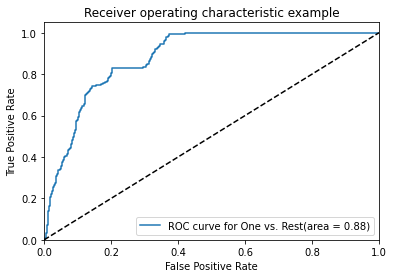

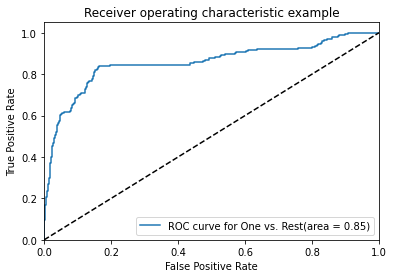

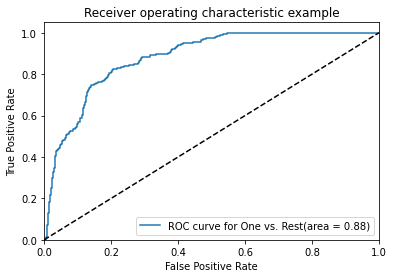

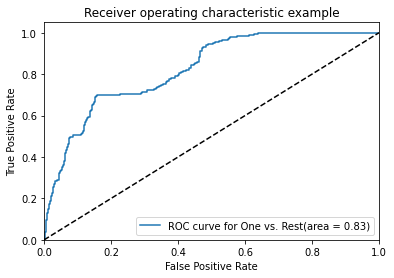

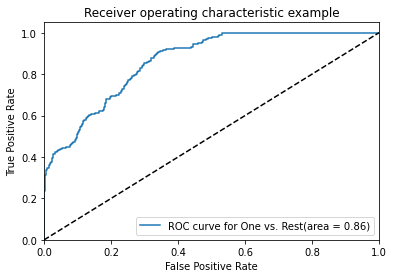

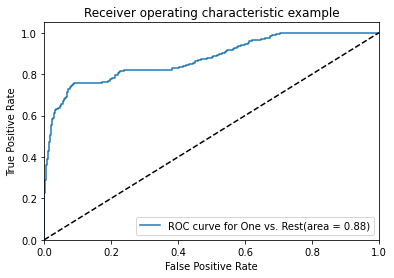

In [61]:
for i in tqdm_notebook(range(24)):
    plt.figure()
    plt.plot(fpr_ovr[i], tpr_ovr[i], label='ROC curve for One vs. Rest(area = %0.2f)' % roc_auc_ovr[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### One vs. One

One vs. One classifier needs __K(K-1)/2__ classes, thus 24*23/2 = 276

In [42]:
model = SVC(random_state=42, C=0.01, kernel='linear', cache_size=1999)
ovo = OneVsOneClassifier(model, n_jobs=-1)
ovo.fit(X_train, y_train)
y_score_ovo = ovo.decision_function(X_test)

In [47]:
fpr_ovo = dict()
tpr_ovo = dict()
roc_auc_ovo = dict()
for i in tqdm_notebook(range(24)):
    fpr_ovo[i], tpr_ovo[i], _ = roc_curve(y_test_one_hot[:, i], y_score_ovo[:, i])
    roc_auc_ovo[i] = auc(fpr_ovo[i], tpr_ovo[i])

C:\Users\yok018\AppData\Local\Temp/ipykernel_34512/335882580.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(24)):


  0%|          | 0/24 [00:00<?, ?it/s]

C:\Users\yok018\AppData\Local\Temp/ipykernel_34512/1374518647.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(24)):


  0%|          | 0/24 [00:00<?, ?it/s]

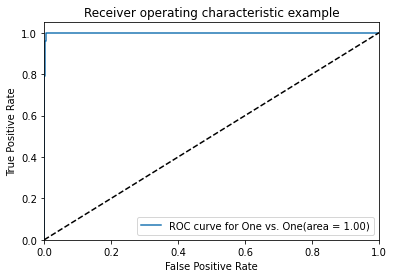

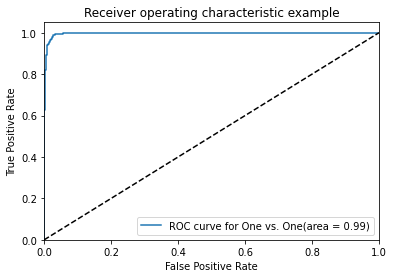

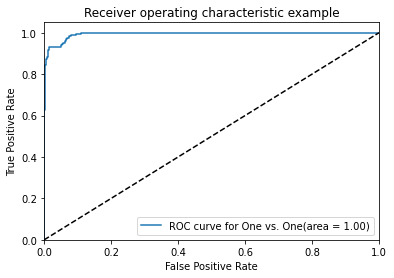

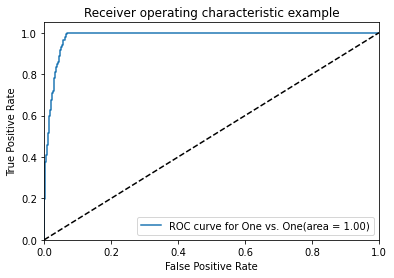

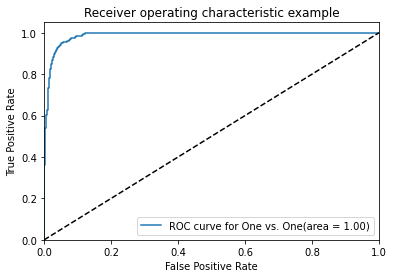

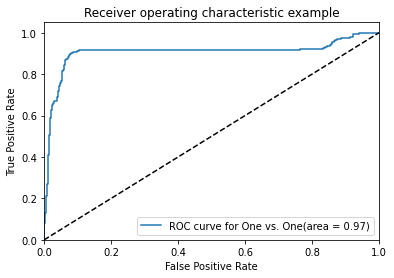

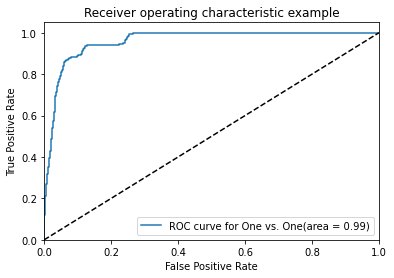

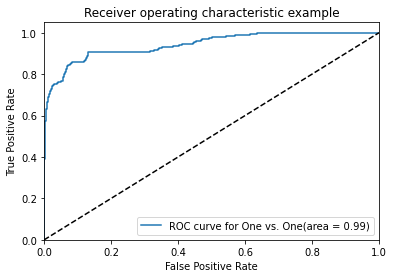

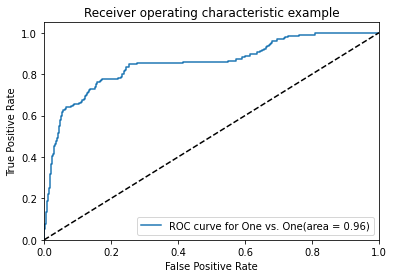

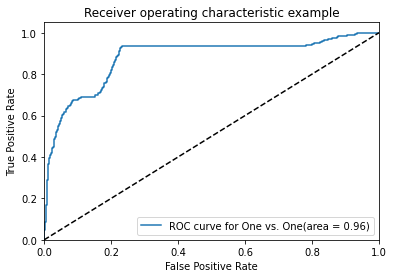

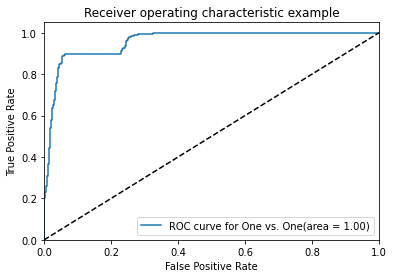

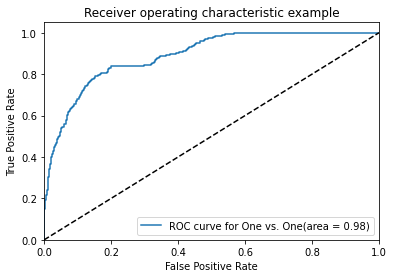

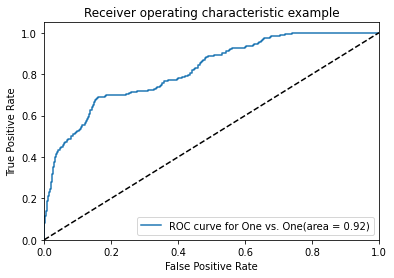

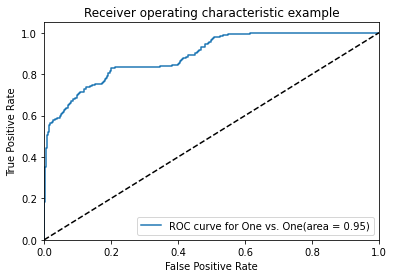

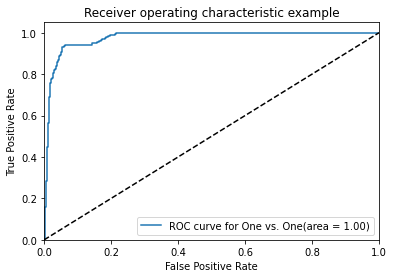

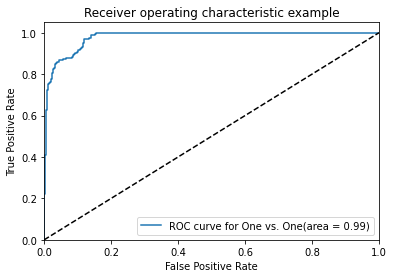

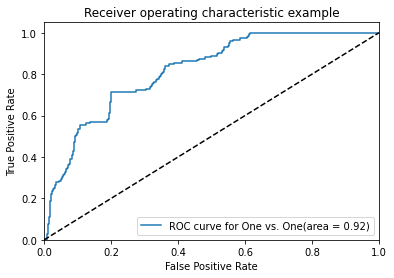

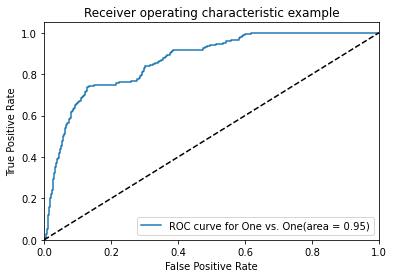

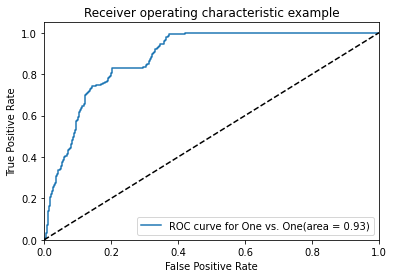

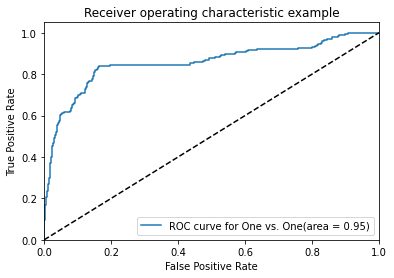

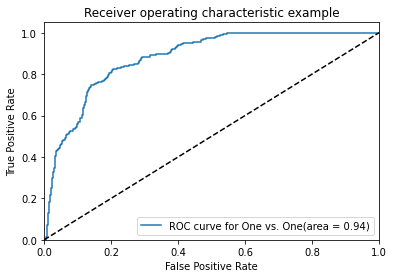

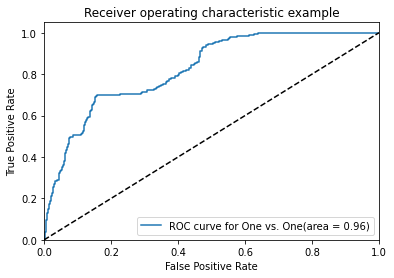

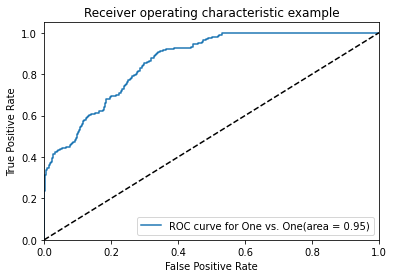

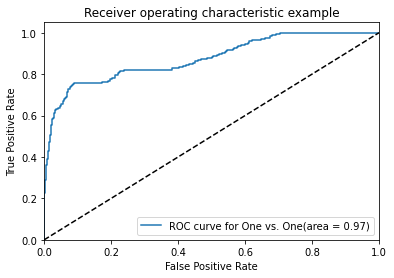

In [48]:
for i in tqdm_notebook(range(24)):
    plt.figure()
    plt.plot(fpr_ovr[i], tpr_ovr[i], label='ROC curve for One vs. One(area = %0.2f)' % roc_auc_ovo[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

## F-1 Score (Precision-Recall Curve)

As said in our proposal, we are going to find F1 score to compare to other model that we are working on (CNN).

In [53]:
from sklearn.metrics import f1_score

# Get predicted score using best hyperparameter
y_pred = final_result.predict(X_test)
f1_score(y_test, y_pred, average=None)

array([0.8847185 , 0.97508897, 0.81471748, 0.87040619, 0.9213691 ,
       0.77798861, 0.81005587, 0.91795482, 0.72106825, 0.59186992,
       0.7308642 , 0.76005961, 0.74820144, 0.67741935, 0.95592287,
       0.79444444, 0.42819843, 0.54228856, 0.70509978, 0.66548673,
       0.73195876, 0.70869565, 0.59961315, 0.77137871])

## Precision-Recall Curve

While Precision-Recall curve does not support multi-label model/dataset, we can use Multiclassifier (shown [here](#multiclassifier))

In [65]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(24):
    precision[i], recall[i], _ = precision_recall_curve(y_test_one_hot[:, i], y_score_ovr[:, i])
    average_precision[i] = average_precision_score(y_test_one_hot[:, i], y_score_ovr[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test_one_hot.ravel(), y_score_ovr.ravel()
)
average_precision["micro"] = average_precision_score(y_test_one_hot, y_score_ovr, average="micro")

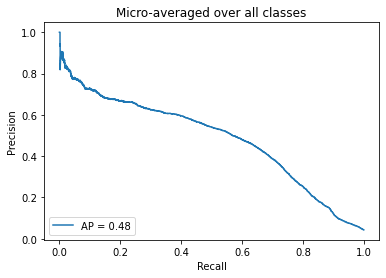

In [67]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

In [68]:
# For saving/restoring notebook session purpose
import dill
dill.dump_session('notebook_env.db') # To save notebook state
# dill.load_session('notebook_env.db') # To load notebook state